<div>
    <h1 align="center"> Cataract and Normal Classification</h1>
    <h5 align="center"> Seyyed Hossein Hosseini</h5>
</div>

<div align="center">
<h5>Please run section "Downloading and loading the  saved model"  to use   the saved model, then run section "Prediction   of images in folder   test_images" to predict.</h5>
</div>


## Setup

In [ ]:
!pip install split-folders[full]

In [ ]:
!pip install -U gdown

In [ ]:
!pip install visualkeras

In [4]:
import os
import splitfolders
import glob
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D 
from tensorflow.keras import regularizers
import visualkeras
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping # for saving best model
import numpy as np
import pandas as pd
%matplotlib inline

In [5]:
print(tensorflow.__version__)
# checking if tensorflow is on GPU or on CPU
print(tensorflow.config.list_physical_devices('GPU'))

2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
!nvidia-smi

Sat Feb 11 17:15:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preprocessing

In [ ]:
# downloading data
!gdown 1KR_7-SMuvH0rLmZawqoIZYm6V1mVjHrA

Downloading...
From: https://drive.google.com/uc?id=1KR_7-SMuvH0rLmZawqoIZYm6V1mVjHrA
To: /content/data.zip
100% 1.14G/1.14G [00:10<00:00, 110MB/s]


In [ ]:
!unzip data.zip

In [ ]:
# transfering extracted 'data folder' to Colab_Notebooks directory in google drive
!mv /content/data /content/drive/MyDrive/Colab_Notebooks

In [7]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/data'

In [ ]:
# creating 2 folders in 'data folder': one for cataract and another for normal class
os.mkdir(data_dir+'/cataract')
os.mkdir(data_dir+'/normal')

In [ ]:
# transfering cataract images to cataract folder
!mv  /content/drive/MyDrive/Colab_Notebooks/data/cataract_* /content/drive/MyDrive/Colab_Notebooks/data/cataract

In [ ]:
# transfering normal images to normal folder
!mv  /content/drive/MyDrive/Colab_Notebooks/data/normal_* /content/drive/MyDrive/Colab_Notebooks/data/normal

In [8]:
print(os.listdir(data_dir))

['cataract', 'normal']


In [9]:
# class-imbalanced dataset 
print(f"Number of catarct samples : {len(os.listdir(data_dir+'/cataract'))}")
print(f"Number of normal samples: {len(os.listdir(data_dir+'/normal'))}")

Number of catarct samples : 728
Number of normal samples: 2194


- **Splitting Data**

    Splitting data folder(that contains 2 subfolders:    cataract and normal) to 3 folders train, validation and test that each of these also includes 2 subfolders: cataract and normal.

In [10]:
out = '/content/drive/MyDrive/Colab_Notebooks/splitted_data'

In [ ]:
# using splitfolders package for splitting 'data' folder to 'splitted_data' folder,
# 'splitted_data' folder contains 3 subfolders train, test and val 
# 80% for train, 10% for development and 10% for test
splitfolders.ratio(data_dir, output=out, seed=23, ratio=(.8, .1, .1),
                   group_prefix=None, move=False)

Copying files: 2922 files [00:43, 67.33 files/s]


In [11]:
os.listdir(out)

['train', 'val', 'test']

In [12]:
print(os.listdir(out + '/test'))
print(os.listdir(out + '/train'))
print(os.listdir(out + '/val'))

['cataract', 'normal']
['cataract', 'normal']
['cataract', 'normal']


In [13]:
# class-imbalanced dataset: ---> train, validation and test sets should have same data distribution
print('total training cataract images :', len(os.listdir(out + '/train/cataract')))
print('total training normal images :', len(os.listdir(out + '/train/normal')))

print('total validation cataract images :', len(os.listdir(out + '/val/cataract')))
print('total validation normal images :', len(os.listdir(out + '/val/normal')))

print('total test cataract images :', len(os.listdir(out + '/test/cataract')))
print('total test normal images :', len(os.listdir(out + '/test/normal')))

total training cataract images : 582
total training normal images : 1755
total validation cataract images : 72
total validation normal images : 219
total test cataract images : 74
total test normal images : 220


- **Visualization**

In [14]:
trn_cfnames = glob.glob(out + '/train/cataract/*.jpg')  # this returns a 'list' in specified pattern
print(trn_cfnames[:3])
trn_nfnames = glob.glob(out + '/train/normal/*.jpg')  
print(trn_nfnames[:3])

['/content/drive/MyDrive/Colab_Notebooks/splitted_data/train/cataract/cataract_2.jpg', '/content/drive/MyDrive/Colab_Notebooks/splitted_data/train/cataract/cataract_373.jpg', '/content/drive/MyDrive/Colab_Notebooks/splitted_data/train/cataract/cataract_669.jpg']
['/content/drive/MyDrive/Colab_Notebooks/splitted_data/train/normal/normal_63.jpg', '/content/drive/MyDrive/Colab_Notebooks/splitted_data/train/normal/normal_2520.jpg', '/content/drive/MyDrive/Colab_Notebooks/splitted_data/train/normal/normal_453.jpg']


(512, 512, 3)
(2100, 2100, 3)


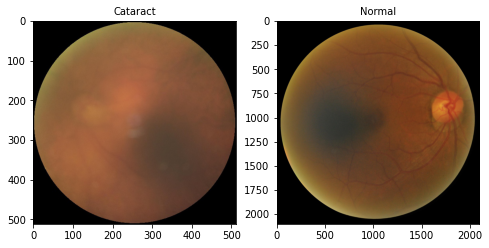

In [15]:
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
img = plt.imread(trn_cfnames[1])
print(img.shape)
plt.imshow(img)
plt.title("Cataract", fontsize=10)

plt.subplot(1, 2, 2)
img = plt.imread(trn_nfnames[1])
print(img.shape)
plt.imshow(img)
plt.title("Normal", fontsize=10);

- **`Input Pipeline`(Loading Datasets from Directories):**

    Option 1: ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,
                                   vertical_flip=True, height_shift_range=0.1)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# loading and iterating
train_set = train_datagen.flow_from_directory(out + '/train/', target_size = (224, 224),
                                              batch_size = 32, class_mode = 'binary', shuffle=True)

valid_set = train_datagen.flow_from_directory(out + '/val/', target_size = (224, 224),
                                              batch_size = 32, class_mode = 'binary', shuffle=True)

# extracting from the main labeled data for estimating generalization error 
test_set = train_datagen.flow_from_directory(out + '/test/', target_size = (224, 224),
                                              batch_size = 32, class_mode = 'binary', shuffle=True)

# confirming that the iterator works
batchX, batchy = train_set.next()
print(f'Batch shape={batchX.shape}')
print('min=%.3f, max=%.3f' % (batchX.min(), batchX.max()))

Found 2337 images belonging to 2 classes.
Found 291 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Batch shape=(32, 224, 224, 3)
min=0.000, max=1.000


Option 2: Image_dataset_from_directory(in this project, this option is used )

In [16]:
# going from raw data on disk to a tf.data.Dataset object that can be used to train a model.
train_ds = image_dataset_from_directory(out + '/train/', labels='inferred', label_mode='binary',
                                         batch_size=32, image_size=(250, 250), shuffle=True)

valid_ds = image_dataset_from_directory(out + '/val/', labels='inferred', label_mode='binary',
                                         batch_size=32, image_size=(250, 250), shuffle=True)

test_ds = image_dataset_from_directory(out + '/test/', labels='inferred', label_mode='binary',
                                         batch_size=32, image_size=(250, 250), shuffle=True)

#checking labels
class_names = train_ds.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}")

for image_batch, labels_batch in train_ds:
   print(image_batch.shape)
   print(labels_batch.shape)
   break

# Normalizing and Data Augmentaton(preprocessing layers)

# ------------------first option: Apply the preprocessing layers to the dataset(using Dataset.map)--------------------------

# Normalizing: scaling pixel values to [0,1] 
# normalizing_layer = tensorflow.keras.layers.Rescaling(1./255)
# Note: to scale pixel values to [-1,1] ---->  tensorflow.keras.layers.Rescaling(1./127.5, offset=-1)
# normalized_train_ds = train_ds.map(lambda x, y: (normalizing_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]
# the pixel values are now in `[0,1]`.
# print(f'min=%.3f, max=%.3f:' %(np.min(first_image), np.max(first_image)))

# ------- Normalizing is done by using a Rescaling layer at the start of model ------


# Data Augmentation
data_augmentation = tensorflow.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                                 layers.RandomRotation(0.1),
                                                 layers.RandomZoom(0.1),])

AUTOTUNE = tensorflow.data.AUTOTUNE
# Apply `data_augmentation` only to the training images.
train_ds = train_ds.map(lambda img, label: (data_augmentation(img), label),
                         num_parallel_calls=AUTOTUNE)

# Use buffered prefetching on all datasets
# Prefetching samples in GPU memory helps maximize GPU utilization.
# Dataset.prefetch overlaps data preprocessing and model execution while training.
# Dataset.cache: keeps the images in memory after they're loaded off disk during the first epoch.
# Dataset.cache: ensures the dataset does not become a bottleneck while training model. 
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
# ---------------------------------------------------------------------------------------------------------


#---------second option: Make the preprocessing layers part of the model to simplify deployment -----------


Found 2337 files belonging to 2 classes.
Found 291 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
0 = cataract
1 = normal
(32, 250, 250, 3)
(32, 1)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Model: CNN

In [ ]:
# Building model
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Normalizing inputs
    x = layers.Rescaling(1.0/255)(inputs)
    
    # x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='block_conv1',
    #       strides=(1, 1), padding='valid', kernel_initializer='glorot_uniform',
    #      kernel_regularizer=regularizers.L1(0.01), kernel_constraint=max_norm(2.))(x)
            
    x = Conv2D(filters=30, kernel_size=(3,3), activation='relu')(x)
    #x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters=60, kernel_size=(3,3), activation='relu')(x) 
    #x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(filters=80, kernel_size=(3,3), activation='relu')(x)
    #x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = Dropout(0.25)(x)



    x = GlobalAveragePooling2D()(x)
    # x = Flatten()(x)

    # x = Dense(units=128, activation='relu')(x)
    # x = Dropout(0.3)(x)
    # x = Dense(units=64, activation='relu')(x)
    x = Dropout(0.25)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = Dense(units, activation=activation)(x)
    return Model(inputs, outputs)

cnn_model = build_model(input_shape=(224, 224, 3), num_classes=2)

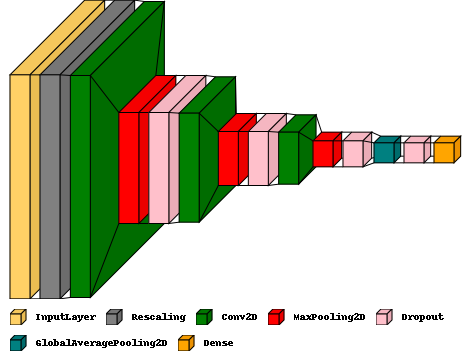

In [ ]:
color_map = defaultdict(dict)
color_map[layers.Rescaling]['fill'] = 'gray'
color_map[Conv2D]['fill'] = 'green'
color_map[MaxPool2D]['fill'] = 'red'
color_map[Dropout]['fill'] = 'pink'
color_map[GlobalAveragePooling2D]['fill'] = 'teal'
color_map[Dense]['fill'] = 'orange'

visualkeras.layered_view(cnn_model, scale_xy=1, legend=True, color_map=color_map)

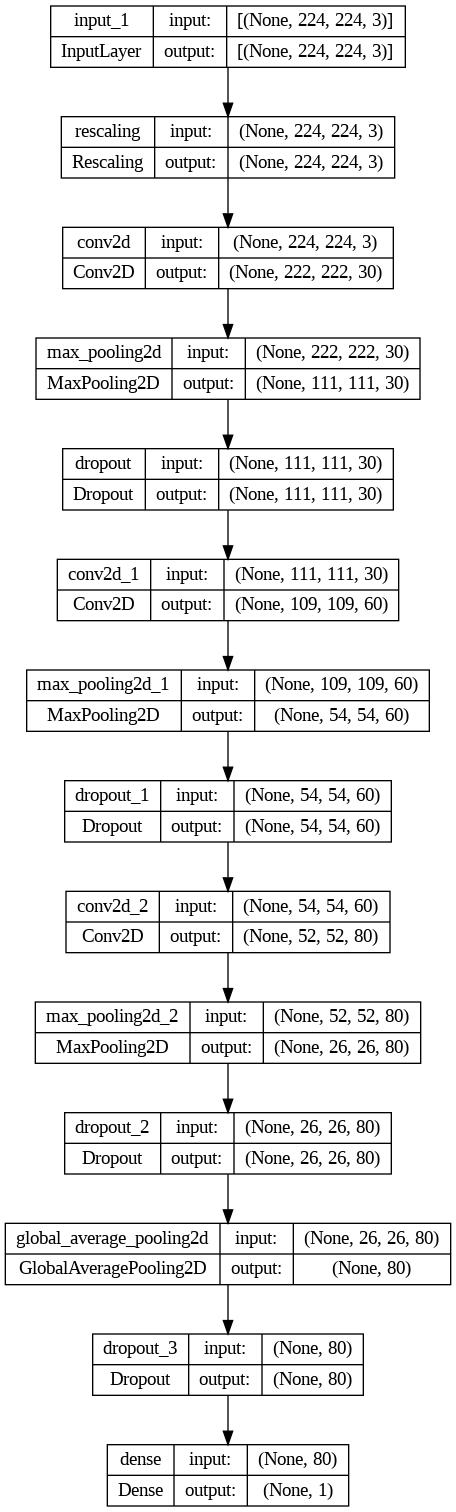

In [ ]:
keras.utils.plot_model(cnn_model, show_shapes=True)

In [ ]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 30)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 30)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 60)      16260     
                                                             

In [ ]:
# Number of parameters of model:
import numpy as np
trainableParams = np.sum([np.prod(v.get_shape()) for v in cnn_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in cnn_model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print(trainableParams)
print(nonTrainableParams)
print(totalParams)

60461
0.0
60461.0


In [ ]:
# Compile
# Adam(learning_rate=0.001)
cnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

- **saving best weights**

In [ ]:
# checkpoint
filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=100)
callbacks_list = [checkpoint, es]

## Training

In [ ]:
# if ImageDataGenerator is selected for input pipeline: train_ds --> train_set  and  valid_ds --> valid_set
history = cnn_model.fit(train_ds, epochs=700, validation_data = valid_ds,
                        callbacks=callbacks_list, verbose=2, workers = 8)

Epoch 1/700

Epoch 1: val_accuracy improved from -inf to 0.75258, saving model to weights.best.hdf5
74/74 - 62s - loss: 0.5461 - accuracy: 0.7642 - val_loss: 0.5476 - val_accuracy: 0.7526 - 62s/epoch - 843ms/step
Epoch 2/700

Epoch 2: val_accuracy improved from 0.75258 to 0.76632, saving model to weights.best.hdf5
74/74 - 4s - loss: 0.4990 - accuracy: 0.7848 - val_loss: 0.5434 - val_accuracy: 0.7663 - 4s/epoch - 56ms/step
Epoch 3/700

Epoch 3: val_accuracy improved from 0.76632 to 0.77663, saving model to weights.best.hdf5
74/74 - 4s - loss: 0.4862 - accuracy: 0.7929 - val_loss: 0.5269 - val_accuracy: 0.7766 - 4s/epoch - 55ms/step
Epoch 4/700

Epoch 4: val_accuracy did not improve from 0.77663
74/74 - 4s - loss: 0.4815 - accuracy: 0.7946 - val_loss: 0.5145 - val_accuracy: 0.7766 - 4s/epoch - 55ms/step
Epoch 5/700

Epoch 5: val_accuracy did not improve from 0.77663
74/74 - 4s - loss: 0.4710 - accuracy: 0.7959 - val_loss: 0.5209 - val_accuracy: 0.7766 - 4s/epoch - 56ms/step
Epoch 6/700



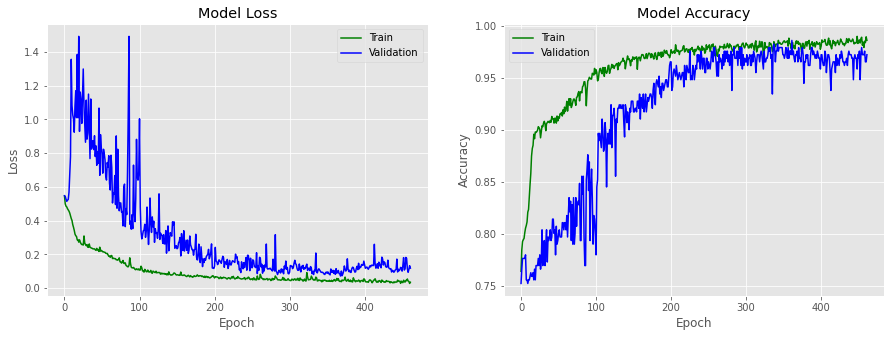

In [ ]:
# plotting loss
plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'b')
plt.legend(["Train", "Validation"])
plt.title(f"Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')  
  
# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend(["Train", "Validation"])
plt.title(f"Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

In [ ]:
# transfering weights.best.hdf5 to Colab_Notebooks directory in google drive
!mv /content/weights.best.hdf5 /content/drive/MyDrive/Colab_Notebooks

### Saving the best model

**In the previous steps, only the best `weights` of model saved in weights.best.hdf5**
- **Saving `Model Architecture`(JSON format):**

In [ ]:
# Saving model architecture to JSON
model_json = cnn_model.to_json()
with open("/content/drive/MyDrive/Colab_Notebooks/model.json", "w") as json_file:
    json_file.write(model_json)

### Downloading and loading the saved model

In [ ]:
# downloading the model
# downloading model architecture(model.json)
import gdown
url = 'https://drive.google.com/uc?id=1lbsZBCInv0ZlitLGDY6A1PKDEYFKdbc_'
out_path = '/content/model.json'
gdown.download(url, out_path, quiet=False)

# downloading model weights(weights.best.hdf5)
url = 'https://drive.google.com/uc?id=1lbZLM1IN9X36PKtqYa7nMt3lmgnukjN_'
out_path = '/content/weights.best.hdf5'
gdown.download(url, out_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1lbsZBCInv0ZlitLGDY6A1PKDEYFKdbc_
To: /content/model.json
100%|██████████| 4.92k/4.92k [00:00<00:00, 5.25MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lbZLM1IN9X36PKtqYa7nMt3lmgnukjN_
To: /content/weights.best.hdf5
100%|██████████| 778k/778k [00:00<00:00, 92.2MB/s]


'/content/weights.best.hdf5'

In [ ]:
# loading model
from tensorflow.keras.models import model_from_json

#loading model architecture(loading JSON and creating model)
#json_file = open('/content/drive/MyDrive/Colab_Notebooks/model.json', 'r')
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


#loading the best saved weights into model
#loaded_model.load_weights("/content/drive/MyDrive/Colab_Notebooks/weights.best.hdf5")
loaded_model.load_weights("/content/weights.best.hdf5")

#compile model (required to make predictions)
loaded_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

### Estimating Generalization Performance

In [ ]:
# 10 % of data is used for test set(294 samples) for estimating generalization performance
loss, accuracy = loaded_model.evaluate(test_ds)
print('Test loss :', loss)
print('Test accuracy :', accuracy)

10/10 [==============================] - 54s 935ms/step - loss: 0.1548 - accuracy: 0.9524
Test loss : 0.15482600033283234
Test accuracy : 0.9523809552192688


### Prediction of images in folder test_images

In [ ]:
# downloading test_images.zip
!gdown 16epIFeSWcYfcCyFCD6s2ZJrVQC4mKMlx
!unzip test_images.zip

Downloading...
From: https://drive.google.com/uc?id=16epIFeSWcYfcCyFCD6s2ZJrVQC4mKMlx
To: /content/test_images.zip

  0% 0.00/225k [00:00<?, ?B/s]
100% 225k/225k [00:00<00:00, 87.4MB/s]
Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/2.jpg       
  inflating: test_images/4.jpg       
  inflating: test_images/1.jpg       
  inflating: test_images/3.jpg       


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def predic_images(dir, res_file):
    # test data preparation
    test_filenames = os.listdir(dir)
    test_df = pd.DataFrame({'name': test_filenames})
    
    # rescaling was done inside the model
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_dataframe(
    test_df,
    dir,
    x_col='name',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=1,  # also creat batch axis  
    shuffle=False)
    
    test_generator.reset()
    # In the case of a two-class (binary) classification problem that sigmoid activation function is often used in the
    # output layer, The predicted probability is taken as the likelihood of the observation belonging to class 1
    predict = (loaded_model.predict(test_generator) > 0.5 ).astype('int32')
    test_df['label'] = predict
    test_df['label'] = test_df['label'].replace({ 0:'cataract', 1:'normal' })
    print(test_df)
    test_df.set_index('name')
    test_df.to_csv(res_file, index=False)
    
predic_images(dir='/content/test_images', res_file='/content/result.csv')

Found 4 validated image filenames.
4/4 [==============================] - 1s 34ms/step
    name     label
0  1.jpg  cataract
1  2.jpg    normal
2  4.jpg  cataract
3  3.jpg  cataract


In [ ]:
import pandas as pd
# result = pd.read_csv('/content/result.csv')
result = pd.DataFrame({'name': ['1.jpg', '2.jpeg', '3.jpeg', '4.jpg'], 'label': ['cataract', 'normal', 'cataract', 'cataract']})
#ref = pd.read_csv('/content/ref.csv')
ref = pd.DataFrame({'name': ['1.jpg', '2.jpeg', '3.jpeg', '4.jpg'], 'true_label': ['cataract', 'normal', 'normal', 'cataract']})
merg = pd.merge(ref, result, on='name', how='left')

from sklearn.metrics import classification_report
print(classification_report(y_true=merg.true_label, y_pred=merg.label))

              precision    recall  f1-score   support

    cataract       0.67      1.00      0.80         2
      normal       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



## Transfer Learning

### Model (using pre-trained model):

In [17]:
# Building model
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Normalizing inputs
    # Pre-trained Xception weights requires that input be scaled from (0, 255) to a range of (-1., +1.),
    # the rescaling layer outputs: `(inputs * scale) + offset`
    x = layers.Rescaling(scale=1/127.5, offset=-1)(inputs)
    
    base_model = tensorflow.keras.applications.Xception( weights="imagenet",  # Load weights pre-trained on ImageNet.
                                                         input_shape=(250, 250, 3), include_top=False,)
    # Freezing the base_model
    base_model.trainable = False
    
    # The base model contains batchnorm layers. We want to keep them in inference mode when we unfreeze the base model
    # for fine-tuning, so we make sure that the base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)  # Regularizing with dropout
   
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = Dense(units, activation=activation)(x)
    return Model(inputs, outputs)

tl_model = build_model(input_shape=(250, 250, 3), num_classes=2)

83683744/83683744 [==============================] - 3s 0us/step


In [18]:
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

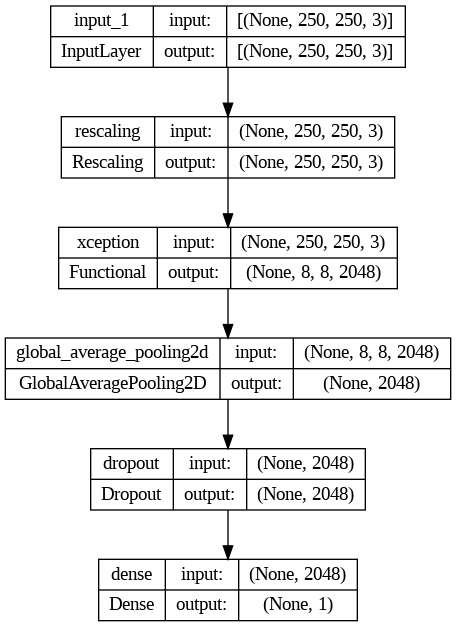

In [19]:
keras.utils.plot_model(tl_model, show_shapes=True)

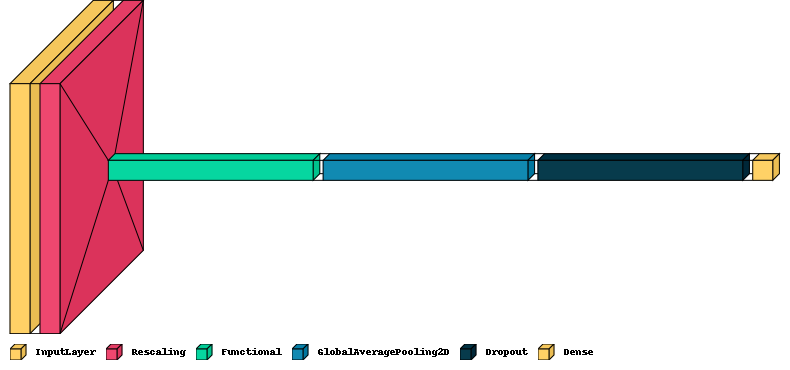

In [20]:
visualkeras.layered_view(tl_model, scale_xy=1, legend=True)

In [21]:
# Number of parameters of model:
import numpy as np
trainableParams = np.sum([np.prod(v.get_shape()) for v in tl_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in tl_model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print(trainableParams)
print(nonTrainableParams)
print(totalParams)

2049
20861480
20863529


In [22]:
# Compile
# Adam(learning_rate=0.001)
tl_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

- **saving best weights**

In [24]:
# checkpoint
# tl_weights.best.hdf5 ---> best weights using transfer learning
filepath = "/content/drive/MyDrive/Colab_Notebooks/tl_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=100)
callbacks_list = [checkpoint, es]

### Training the top layer

In [25]:
# if ImageDataGenerator is selected for input pipeline: train_ds --> train_set  and  valid_ds --> valid_set
history = tl_model.fit(train_ds, epochs=300, validation_data = valid_ds,
                        callbacks=callbacks_list, verbose=2, workers = 8)

Epoch 1/300

Epoch 1: val_accuracy improved from -inf to 0.91409, saving model to /content/drive/MyDrive/Colab_Notebooks/tl_weights.best.hdf5
74/74 - 416s - loss: 0.3360 - accuracy: 0.8695 - val_loss: 0.2259 - val_accuracy: 0.9141 - 416s/epoch - 6s/step
Epoch 2/300

Epoch 2: val_accuracy improved from 0.91409 to 0.93127, saving model to /content/drive/MyDrive/Colab_Notebooks/tl_weights.best.hdf5
74/74 - 16s - loss: 0.2090 - accuracy: 0.9238 - val_loss: 0.1869 - val_accuracy: 0.9313 - 16s/epoch - 220ms/step
Epoch 3/300

Epoch 3: val_accuracy improved from 0.93127 to 0.93471, saving model to /content/drive/MyDrive/Colab_Notebooks/tl_weights.best.hdf5
74/74 - 17s - loss: 0.1777 - accuracy: 0.9354 - val_loss: 0.1685 - val_accuracy: 0.9347 - 17s/epoch - 224ms/step
Epoch 4/300

Epoch 4: val_accuracy improved from 0.93471 to 0.93814, saving model to /content/drive/MyDrive/Colab_Notebooks/tl_weights.best.hdf5
74/74 - 17s - loss: 0.1599 - accuracy: 0.9418 - val_loss: 0.1604 - val_accuracy: 0.93

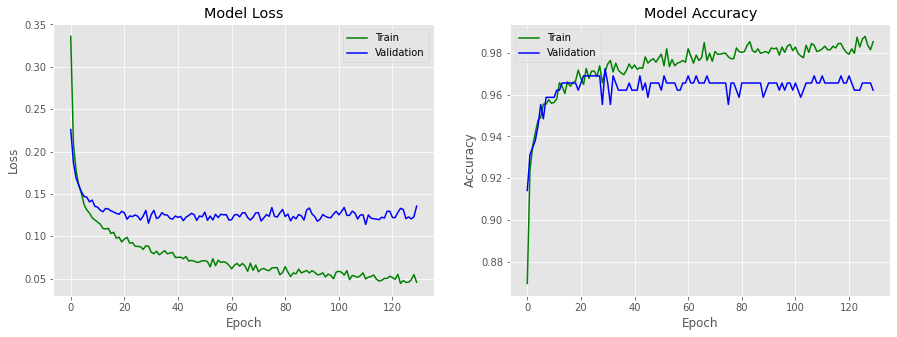

In [26]:
# plotting loss
plt.style.use("ggplot")
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'b')
plt.legend(["Train", "Validation"])
plt.title(f"Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')  
  
# plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend(["Train", "Validation"])
plt.title(f"Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

### Saving the best model

In the previous steps, only the best `weights` of model saved in weights.best.hdf5
- **Saving `Model Architecture`(JSON format)**:

In [27]:
# Saving model architecture to JSON
model_json = tl_model.to_json()
with open("/content/drive/MyDrive/Colab_Notebooks/tl_model.json", "w") as json_file:
    json_file.write(model_json)

### Downloading and loading the saved model

In [29]:
# downloading the model
# downloading model architecture(tl_model.json)
import gdown
url = 'https://drive.google.com/uc?id=187-DAXsJ8Pk3cp_EAKyU8gMxM3GwE3lx'
out_path = '/content/tl_model.json'
gdown.download(url, out_path, quiet=False)

# downloading model weights(tl_weights.best.hdf5)
url = 'https://drive.google.com/uc?id=1v0IrqRxav5SstsG9sqbx7D5pclr6xKf9'
out_path = '/content/tl_weights.best.hdf5'
gdown.download(url, out_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=187-DAXsJ8Pk3cp_EAKyU8gMxM3GwE3lx
To: /content/tl_model.json
100%|██████████| 76.4k/76.4k [00:00<00:00, 43.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v0IrqRxav5SstsG9sqbx7D5pclr6xKf9
To: /content/tl_weights.best.hdf5
100%|██████████| 83.7M/83.7M [00:00<00:00, 226MB/s]


'/content/tl_weights.best.hdf5'

In [31]:
# loading model
from tensorflow.keras.models import model_from_json

#loading model architecture(loading JSON and creating model)
#json_file = open('/content/drive/MyDrive/Colab_Notebooks/model.json', 'r')
json_file = open('/content/tl_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


#loading the best saved weights into model
#loaded_model.load_weights("/content/drive/MyDrive/Colab_Notebooks/weights.best.hdf5")
loaded_model.load_weights("/content/tl_weights.best.hdf5")

#compile model (required to make predictions)
loaded_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

### Estimating Generalization Performance

In [32]:
# 10 % of data is used for test set(294 samples) for estimating generalization performance
loss, accuracy = loaded_model.evaluate(test_ds)
print('Test loss :', loss)
print('Test accuracy :', accuracy)

10/10 [==============================] - 68s 353ms/step - loss: 0.1746 - accuracy: 0.9388
Test loss : 0.17458054423332214
Test accuracy : 0.9387755393981934


### Prediction of images in folder test_images

In [ ]:
# downloading test_images.zip
!gdown 16epIFeSWcYfcCyFCD6s2ZJrVQC4mKMlx
!unzip test_images.zip

In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def predic_images(dir, res_file):
    # test data preparation
    test_filenames = os.listdir(dir)
    test_df = pd.DataFrame({'name': test_filenames})
    
    # rescaling was done inside the model
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_dataframe(
    test_df,
    dir,
    x_col='name',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=1,  # also creat batch axis  
    shuffle=False)
    
    test_generator.reset()
    # In the case of a two-class (binary) classification problem that sigmoid activation function is often used in the
    # output layer, The predicted probability is taken as the likelihood of the observation belonging to class 1
    predict = (loaded_model.predict(test_generator) > 0.5 ).astype('int32')
    test_df['label'] = predict
    test_df['label'] = test_df['label'].replace({ 0:'cataract', 1:'normal' })
    print(test_df)
    test_df.set_index('name')
    test_df.to_csv(res_file, index=False)
    
predic_images(dir='/content/test_images', res_file='/content/result.csv')

In [ ]:
import pandas as pd
# result = pd.read_csv('/content/result.csv')
result = pd.DataFrame({'name': ['1.jpg', '2.jpeg', '3.jpeg', '4.jpg'], 'label': ['cataract', 'normal', 'cataract', 'cataract']})
#ref = pd.read_csv('/content/ref.csv')
ref = pd.DataFrame({'name': ['1.jpg', '2.jpeg', '3.jpeg', '4.jpg'], 'true_label': ['cataract', 'normal', 'normal', 'cataract']})
merg = pd.merge(ref, result, on='name', how='left')

from sklearn.metrics import classification_report
print(classification_report(y_true=merg.true_label, y_pred=merg.label))